## **1. Introduction**

> Imagine giving a blank canvas and a paintbrush to a rookie artist who has never drawn before. Every day, this artist tries to sketch faces. A tough critic watches over them, pointing out flaws relentlessly. Slowly, the artist improves, until one day, their portraits are indistinguishable from real photographs.

That’s the magic of **GANs (Generative Adversarial Networks)**.

* **Generator** → the rookie artist (creates faces from random noise).
* **Discriminator** → the art critic (judges real vs fake).

In this notebook, we’ll train a **Deep Convolutional GAN (DCGAN)** on the **CelebA-HQ dataset** (30k+ high-quality celebrity faces, resized to 256x256). By the end, you’ll see an AI “learn” to paint realistic celebrity portraits pixel by pixel.



## **2. Setup**

Let’s import the essentials and grab the dataset.

In [ ]:
project_name = 'CelebA-HQ'

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256'
od.download(dataset_url)

Skipping, found downloaded files in "./celebahq-resized-256x256" (use force=True to force download)


In [ ]:
import os


DATA_DIR = './celebahq-resized-256x256'
print(os.listdir(DATA_DIR))

['celeba_hq_256']


In [ ]:
print(os.listdir(DATA_DIR+'/celeba_hq_256')[:10])

['03814.jpg', '27532.jpg', '23667.jpg', '04473.jpg', '17339.jpg', '11041.jpg', '16513.jpg', '06216.jpg', '19869.jpg', '13256.jpg']


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## 🖼️ Preparing Our Celebrity Portraits

Before our rookie artist (the generator) can start painting, we need to **set up the reference gallery** of real celebrity portraits. But we can’t just throw in random photos we need them **uniform, standardized, and ready for practice**.

Here’s what we do:

1. **Set the stage**

In [ ]:
image_size = 256
batch_size = 32

stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

   * `image_size=256` → all faces are resized to **256×256**, like giving every canvas the same dimensions.
   * `batch_size=32` → the number of portraits shown to the artist in one round.
   * `stats` → scales pixels from `[0,1]` to `[-1,1]`. This matches the generator’s **Tanh output**, keeping learning stable.

2. **Load & Transform the portraits**

In [ ]:
# Preprocessing pipeline
train_ds = ImageFolder(
    root=DATA_DIR,
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)

# DataLoader
train_dl = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True, num_workers=3, pin_memory=True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


   * `ImageFolder` → tells PyTorch: *“treat this folder of images as a dataset.”*
   * `Resize` + `CenterCrop` → ensure every face is the same size and centered (like cropping portraits to focus on the face).
   * `ToTensor` → converts images into tensors (the language our AI understands).
   * `Normalize` → rescales colors so the generator and discriminator speak the same “pixel language.”
   * `DataLoader` → creates a conveyor belt that hands the critic and artist mini-batches of images, shuffled every epoch for variety.


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

### 📝 Teaching Text for the Two Cells

**1. Denormalization Function** :
When training GANs, we normalize images to the range `[-1, 1]` (using `T.Normalize`). But when we want to **see the results** (plot the images), we need to “undo” that normalization.

👉 This `denorm` function rescales the tensors back to the original `[0, 1]` range so matplotlib can display them properly.

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

**2. Visualization Utilities**


* `show_images`: takes a batch of tensors, denormalizes them, arranges them into a neat grid (`make_grid`), and shows them.
* `detach()`: makes sure gradients aren’t tracked (since we’re only visualizing).
* `permute(1,2,0)`: reorders tensor dimensions from PyTorch format `(C,H,W)` to matplotlib format `(H,W,C)`.


* `show_batch`: grabs **one batch** from the dataloader (`dl`) and calls `show_images`.
* Super handy to quickly **preview what your dataset looks like after preprocessing** (resize, crop, normalize).




In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))


def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

✅ Together, these functions act like your **GAN microscope**  they let you peek at your dataset and later your generator’s output, ensuring everything is working as intended.

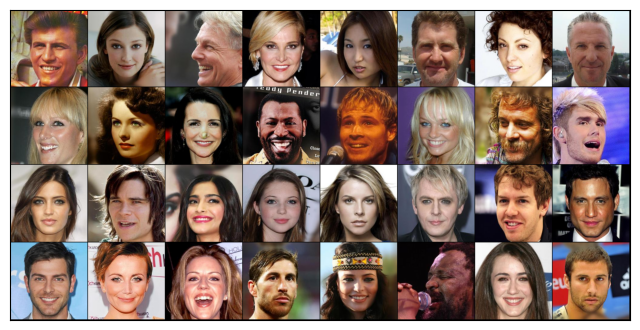

In [ ]:
show_batch(train_dl)

This block makes training **device-agnostic and GPU-ready**:

1. **`get_default_device`** → picks GPU (`cuda`) if available, else CPU.
2. **`to_device`** → moves tensors (or lists/tuples) onto the chosen device efficiently.
3. **`DeviceDataLoader`** → wraps a PyTorch DataLoader so every batch is automatically pushed to the right device.

✅ Together, they remove the hassle of calling `.to(device)` everywhere and let the training loop run seamlessly on GPU or CPU.


In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

👉 This wraps the dataloader so every batch is automatically moved to the GPU (CUDA) for faster training.

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 8 x 8

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 4 x 4

    nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

This is the **Discriminator for CelebA-HQ at 256×256 resolution**.

* The input is a **3×256×256 RGB image**.
* Each block is **Conv2D → BatchNorm → LeakyReLU**:

  * Convolution downsamples the image (halves width & height).
  * BatchNorm stabilizes training.
  * LeakyReLU introduces non-linearity and avoids “dying ReLUs.”
* With each step, the **spatial resolution shrinks** (`256 → 128 → 64 → … → 4`), while **channels grow** (`3 → 64 → … → 2048`).
* Finally, a `1×1` feature map is reduced to a **single scalar**, passed through `Sigmoid()` → giving the probability that the image is **real (close to 1)** or **fake (close to 0)**.

✅ In essence: The Discriminator acts as a **deep CNN classifier**, trained to be a **lie detector** for your GAN.


In [ ]:
discriminator = to_device(discriminator, device)

👉 We move the discriminator to the GPU (CUDA) for faster training.




In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 16 x 128 x 128

    nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

The **generator** takes a random noise vector (`latent_size = 128`) and transforms it step by step into a **256×256 RGB image**.

* Each `ConvTranspose2d` layer acts like an “upscaling block,” gradually doubling the image size (4×4 → 8×8 → … → 256×256).
* `BatchNorm2d` stabilizes training.
* `ReLU` introduces non-linearity and helps the network learn richer features.
* Finally, `Tanh` squashes the pixel values to `[-1, 1]`, matching the normalization of our dataset.

👉 In short: the generator is like an “artist” starting with random noise and progressively painting a high-resolution face.

---

✨ **Bonus — Understanding CNN parameters**:

* **Kernel size** = how big my magnifying glass is.
* **Stride** = how far I move the magnifying glass each step.
* **Padding** = do I add a border so the edges also get looked at properly?

---



torch.Size([32, 3, 256, 256])


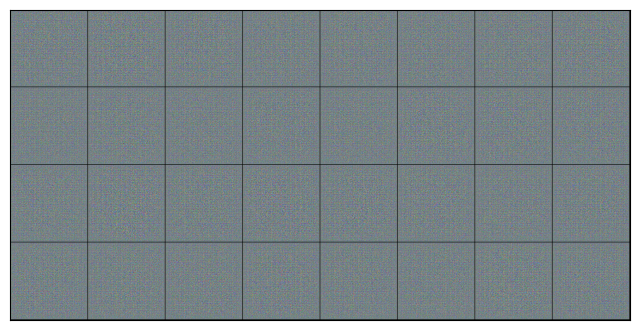

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

👉 We move the generator to the GPU (CUDA) for faster training.

In [ ]:
def train_discriminator(real_images, opt_d):
    # real_images: batch of real face images from CelebA
    opt_d.zero_grad()

    # 1. Pass real CelebA faces through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # 2. Generate fake faces using generator
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # 3. Pass generated faces through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images.detach())   # detach to avoid backprop to generator
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # 4. Update discriminator: maximize real/fake separation
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

The **discriminator** acts like an art critic for faces. Its job is to separate **real celebrity faces** from **fake ones generated by the generator**.

The process happens in four steps:

1. **Judge Real Faces**

   * Real images from the **CelebA dataset** are fed into the discriminator.
   * The target label is **1 (real)**.
   * Loss is computed: how well did it recognize real faces?

2. **Judge Fake Faces**

   * A random noise vector is passed to the generator to create **fake faces**.
   * These fakes are shown to the discriminator.
   * The target label is **0 (fake)**.
   * Loss is computed: how well did it catch the fakes?

3. **Combine Losses**

   * Total loss = loss on real + loss on fake.
   * This ensures the critic balances both tasks: praising the real and rejecting the fake.

4. **Update the Critic**

   * Backpropagation updates the discriminator’s weights.
   * Each step makes it a sharper critic, harder to fool.

---

⚡ **Key Idea:**

* The discriminator doesn’t just “learn faces.”
* It learns the **essence of what makes a face real** vs. a flawed fake.
* As it improves, the generator is forced to get better at creating realistic CelebA-like faces.



In [ ]:
def train_generator(opt_g):
    # Generator’s job: create fake CelebA-like faces good enough to fool the critic
    opt_g.zero_grad()

    # 1. Generate fake faces from random noise
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # 2. Discriminator evaluates the fake faces
    preds = discriminator(fake_images)

    # 3. Trick the critic: pretend fakes are real (target = 1)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # 4. Update generator: push it to make more realistic CelebA faces
    loss.backward()
    opt_g.step()

    return loss.item()

The **generator** is like a *forger* trying to paint fake CelebA faces that look real enough to trick the critic (discriminator).

**Step-by-step logic:**

1. 🎲 **Noise in, face out**
   We start with pure randomness (latent vector) and let the generator convert it into a batch of fake faces.

2. 🕵️ **Critic’s judgment**
   These fake faces are passed into the discriminator, which tries to classify them as fake.

3. 🎭 **Fooling strategy**
   Instead of aiming for `0` (fake), we assign the label `1` (real).
   → The generator is literally “lying” to the critic, trying to maximize the chance that fake faces are accepted as real.

4. ⚡ **Learning update**
   The loss is backpropagated, and the generator’s weights are adjusted so its next batch of fake CelebA faces looks more realistic.

👉 In short: *The generator gets better at painting faces by constantly trying to deceive the discriminator.*


In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

We create a generated folder (if it doesn’t exist) to save the images produced by our generator.

In [ ]:
def save_samples(index, latent_tensors, show=True):
    # Generate fake images
    fake_images = generator(latent_tensors).detach()

    # Save to disk
    fake_fname = f'generated-images-{index:04d}.png'
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)

    # Optionally display
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images).cpu(), nrow=8).permute(1, 2, 0))


In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


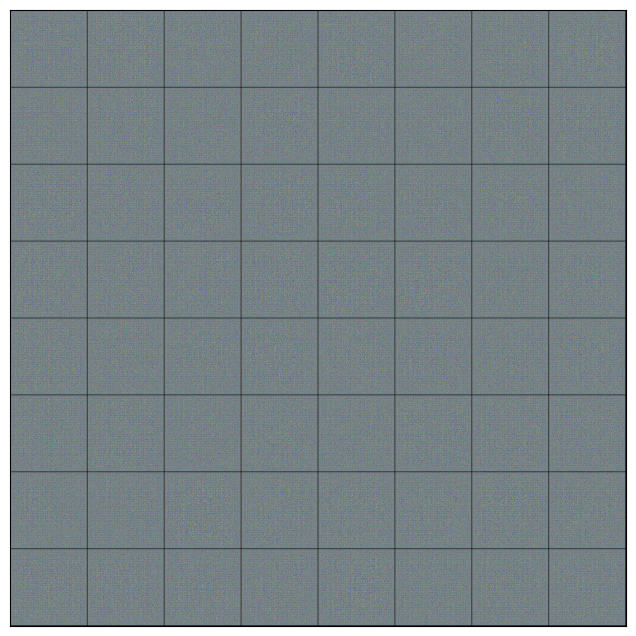

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl, leave=False):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

This function runs the **GAN training process** on CelebA.

1. **Setup:**

   * Clears GPU cache.
   * Initializes Adam optimizers for both discriminator & generator.
   * Prepares lists to track losses and scores.

2. **Epoch loop:**

   * For each batch of CelebA images:

     * 🎯 **Discriminator** learns to separate real CelebA faces from fake ones.
     * 🎨 **Generator** learns to fool the discriminator with better fakes.

3. **Tracking:**

   * Records generator loss, discriminator loss, and average scores for real vs fake images.
   * Logs progress each epoch.

4. **Visualization:**

   * Saves generated samples using a fixed noise vector so we can **see improvements over time**.

👉 In short: this is the **engine room** of training  where the generator and discriminator continuously battle and improve, epoch by epoch.



In [ ]:
lr = 0.0002
epochs = 30

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 6.5462, loss_d: 0.0017, real_score: 0.9995, fake_score: 0.0012
Saving generated-images-0001.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 41.7635, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 40.2707, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 39.9191, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 39.5451, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 39.1827, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.0216, loss_d: 0.3893, real_score: 0.9807, fake_score: 0.2547
Saving generated-images-0007.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.5536, loss_d: 0.3265, real_score: 0.9903, fake_score: 0.2529
Saving generated-images-0008.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 9.1322, loss_d: 0.0065, real_score: 0.9961, fake_score: 0.0026
Saving generated-images-0009.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 7.1104, loss_d: 0.4539, real_score: 0.9275, fake_score: 0.1823
Saving generated-images-0010.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 10.2406, loss_d: 0.5184, real_score: 1.0000, fake_score: 0.3203
Saving generated-images-0011.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.4437, loss_d: 0.1174, real_score: 0.9572, fake_score: 0.0561
Saving generated-images-0012.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 8.3779, loss_d: 0.0624, real_score: 0.9929, fake_score: 0.0512
Saving generated-images-0013.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 5.5284, loss_d: 0.0772, real_score: 0.9458, fake_score: 0.0154
Saving generated-images-0014.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.8547, loss_d: 0.0235, real_score: 0.9998, fake_score: 0.0222
Saving generated-images-0015.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 10.1878, loss_d: 0.0118, real_score: 0.9885, fake_score: 0.0001
Saving generated-images-0016.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 13.2237, loss_d: 0.4293, real_score: 0.9999, fake_score: 0.2476
Saving generated-images-0017.png


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 1.2695, loss_d: 0.4278, real_score: 0.7851, fake_score: 0.0708
Saving generated-images-0018.png


  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');